This notebook will explore an alternative to measuring effective radii of galaxies to compare size ratio distributions. 

In [19]:
import numpy as np
import sys

from astropy.table import Table
from astropy.io import fits
from astropy.visualization import simple_norm

from scipy.stats import scoreatpercentile

#for smoothing the images...I think
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.modeling import models, fitting

from matplotlib import pyplot as plt
%matplotlib inline

import os
homedir = os.getenv("HOME")

sys.path.append(homedir+"/github/halphagui/")
from photwrapper import ellipse
from photwrapper import display_image

In [2]:
#test galaxy (VFID0901 --> NGC3683)
#cutout images
w1_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W1.fits')
w3_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W3.fits')

#psf images
w1_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W1.fits')
w3_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W3.fits')

## Convolve W1 image using Gaussian fits

In [3]:
fit_t = fitting.LevMarLSQFitter()

amp_w1 = np.max(w1_psf)
#sigma = np.std(w1_psf)
sigma = 3     #resulting model STD is too infinitesimal otherwise. Choose a somewhat arbitrary sigma to start.
y_max_w1, x_max_w1 = w1_psf.shape

#set up symmetric model
g2_w1 = models.Gaussian2D(amp_w1, x_max_w1/2, y_max_w1/2, sigma, sigma)

#define indices on a grid corresponding to pixel coordinates
yi_w1, xi_w1 = np.indices(w1_psf.shape)

#fitting of model g2 to the W1 PSF
g_w1 = fit_t(g2_w1, xi_w1, yi_w1, w1_psf)

#same sigma as above, so no need to redefine variable
amp_w3 = np.max(w3_psf)
#redefined in case shapes are different
y_max_w3, x_max_w3 = w3_psf.shape

g2_w3 = models.Gaussian2D(amp_w3, x_max_w3/2, y_max_w3/2, sigma, sigma)

yi_w3, xi_w3 = np.indices(w3_psf.shape)

#fitting of model g2 to the W3 PSF
g_w3 = fit_t(g2_w3, xi_w3, yi_w3, w3_psf)

In [4]:
#but I would still like to extract the x- and y- STDDEVs of the residual, just because.
#note --> STDDEVs add in quadrature.
sig_kernelx = np.sqrt(g_w3.x_stddev[0]**2 - g_w1.x_stddev[0]**2)
sig_kernely = np.sqrt(g_w3.y_stddev[0]**2 - g_w1.y_stddev[0]**2)

In [5]:
smoothed_w1 = convolve(w1_im, Gaussian2DKernel(x_stddev=sig_kernelx, y_stddev=sig_kernely, theta=0.0))

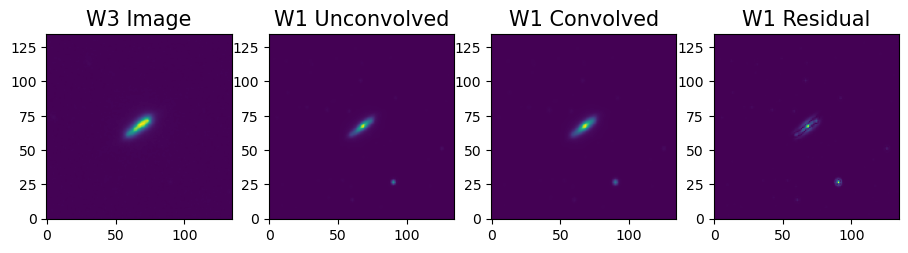

In [6]:
images = [w3_im,w1_im,smoothed_w1,np.abs(smoothed_w1-w1_im)]
titles = ['W3 Image','W1 Unconvolved','W1 Convolved','W1 Residual']

plt.figure(figsize=(11,9))
for i, im in enumerate(images):
    plt.subplot(1,4,i+1)
    plt.imshow(im,origin='lower')
    plt.title(titles[i],fontsize=15)

plt.savefig(homedir+'/Desktop/VFID0901_kerneltest.png', dpi=100, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [7]:
#I guess I need a professional check now. The differences between W3 and W1 (unconvolved) are such that
#W1 looks considerably more narrow, suggesting that the resolution is perhaps more nontrivial than initially
#suspected (see notes in cell above). Thus, convolution is needed. But does this PSF yield sufficient "blurring?"

---

## Performing Aperture Photometry on W3 Unconvolved and W1 Convolved Images

In [14]:
#w3 image path
w3_path = homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W3.fits'

#mask
wise_mask_path = homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-wise-mask.fits'

#obj catalog
vf_cat = Table.read(homedir+'/Desktop/VF_WISESIZE.fits')

objra = vf_cat['RA'][vf_cat['VFID']=='VFID0901']
objdec = vf_cat['DEC'][vf_cat['VFID']=='VFID0901']

In [15]:
#the way I have set up this photwrapper is that it will accept a headerless
#smoothed w1 image, and use the image2 (which MUST BE A PATH TO THE FITS IMAGE)
#header for the W1 header (which is fine, since the pixelscales are the same methinks?)

e_obj = ellipse(smoothed_w1,image2=w3_path,mask=wise_mask_path, objra=objra, objdec=objdec)
e_obj.run_two_image_phot()

getting object position from RA and DEC
(67.37913036894157, 66.87929926902513) 67.37913036894157 67.37913036894157 66.87929926902513 66.87929926902513


<Figure size 640x480 with 0 Axes>

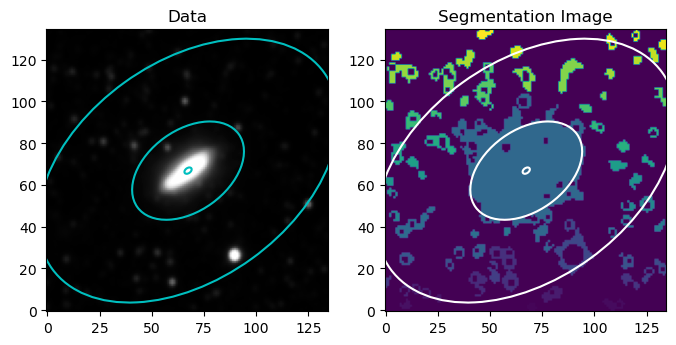

In [16]:
plotname='W3apertures.png'
e_obj.draw_phot_apertures(plotname=plotname)

/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


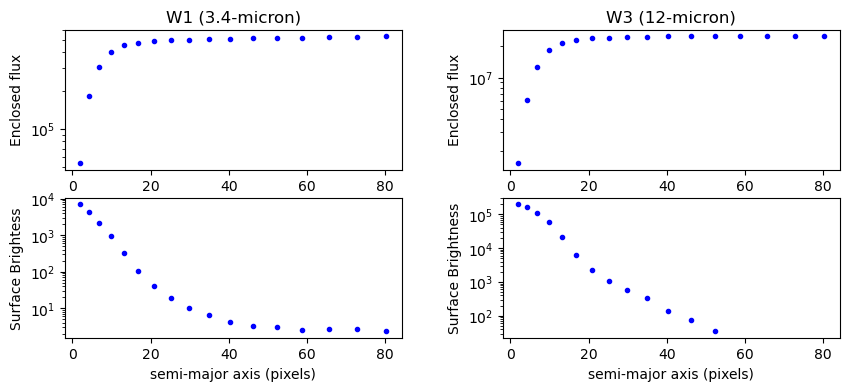

In [18]:
e_obj.plot_profiles(galaxyname='VFID0901')